In [ ]:
pip install --upgrade keras-cv-attention-models


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.0/190.0 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.6/802.6 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.2 MB/s eta 0:00:00


DENSENET-121 (LATEST) + SWIN-T ENSEMBLE WITH MIXUP

[STAGE 1] Loading and Preprocessing Data...


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/incomplete.RBT9MK_1.0.0/malaria-train.tfrecord*...:   0%|         …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.
✓ Total samples: 27558
✓ Train: 19290 (70%)
✓ Val: 5511 (20%)
✓ Test: 2757 (10%)

✓ Applying Mixup augmentation to training data...
✓ Mixup augmentation applied with alpha = 0.2
⏱ Stage 1 Time: 67.43 seconds

[STAGE 2A] Building Feature Extractors...
114320936/114320936 [==============================] - 1s 0us/step
>>>> Load pretrained from: /root/.keras/models/swin_transformer_v2_tiny_window8_256_imagenet.h5
✓ DenseNet121 Extractor: 7,562,304 parameters
✓ Swin-T Extractor:      28,859,666 parameters

[STAGE 2B] Partially Fine-tuning Models with Mixup...

✓ Fine-tuning DenseNet121_Extractor with Mixup...
  Trainable params in backbone layers: 0
Epoch 1/15
603/603 [==============================] - 109s 149ms/step - loss: 0.4606 - accuracy: 0.8407 - val_loss: 0.1707 - val_accuracy: 0.9516
Epoch 2/15
603/603 [==============================] - 86s 143ms/step - loss: 

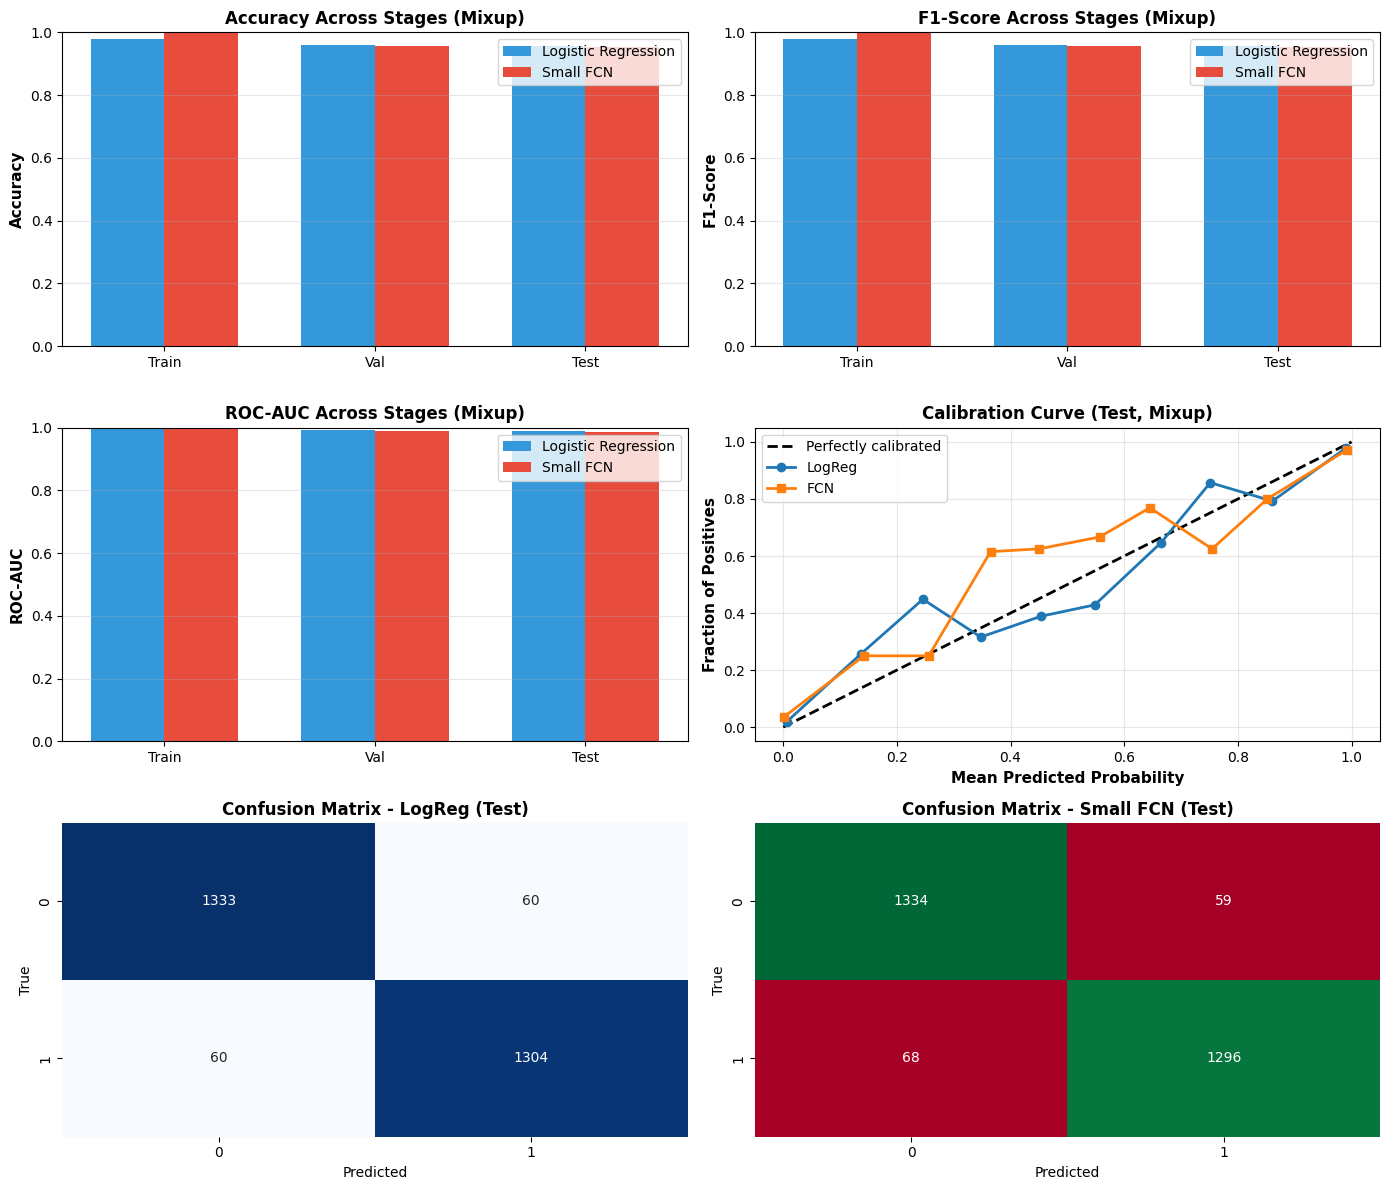

In [ ]:
# ======================= MUST BE FIRST LINES =======================
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
os.environ["TF_USE_LEGACY_KERAS"] = "1"
# ==================================================================

import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers, Model
import warnings
import time

warnings.filterwarnings('ignore')

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("=" * 70)
print("DENSENET-121 (LATEST) + SWIN-T ENSEMBLE WITH MIXUP")
print("=" * 70)

# ============================================================================
# MIXUP DATA AUGMENTATION
# ============================================================================
def mixup(images, labels, alpha=0.2, num_classes=2):
    """
    Apply Mixup augmentation to a batch of images and *one-hot* labels.
    x_mix = λ * x_i + (1-λ) * x_j
    y_mix = λ * y_i + (1-λ) * y_j
    """
    batch_size = tf.shape(images)[0]

    # Sample lambda from Beta(alpha, alpha) via symmetry trick
    lam = tf.random.uniform([], 0.0, 1.0)
    lam = tf.maximum(lam, 1.0 - lam)

    # Random permutation of indices
    indices = tf.random.shuffle(tf.range(batch_size))

    # Ensure labels are one-hot
    labels_one_hot = tf.one_hot(tf.cast(labels, tf.int32), depth=num_classes)
    labels_shuffled = tf.gather(labels_one_hot, indices)

    mixed_images = lam * images + (1.0 - lam) * tf.gather(images, indices)
    mixed_labels = lam * labels_one_hot + (1.0 - lam) * labels_shuffled

    return mixed_images, mixed_labels, lam

def mixup_batch(images, labels, alpha=0.2, num_classes=2):
    mixed_images, mixed_labels, lam = mixup(images, labels, alpha=alpha, num_classes=num_classes)
    return mixed_images, tf.cast(mixed_labels, tf.float32)

# ============================================================================
# STAGE 1: LOAD AND PREPROCESS DATA (70/20/10 split)
# ============================================================================
print("\n[STAGE 1] Loading and Preprocessing Data...")
stage1_start = time.time()

def load_malaria_data():
    """Load malaria dataset with 70/20/10 split"""
    (train_data, info) = tfds.load(
        'malaria',
        split='train',
        with_info=True,
        as_supervised=True
    )

    total_samples = info.splits['train'].num_examples
    train_size = int(0.7 * total_samples)
    val_size = int(0.2 * total_samples)

    train_data = train_data.take(train_size)
    val_test_data = tfds.load('malaria', split='train', as_supervised=True).skip(train_size)
    val_data = val_test_data.take(val_size)
    test_data = val_test_data.skip(val_size)

    return train_data, val_data, test_data, total_samples

def preprocess_image(image, label, target_size=224):
    """Preprocess image for DenseNet121 and Swin-T (resize + normalize)."""
    image = tf.image.resize(image, (target_size, target_size))
    image = image / 255.0
    return image, label

# Load data
train_data, val_data, test_data, total_samples = load_malaria_data()

train_size = int(0.7 * total_samples)
val_size = int(0.2 * total_samples)
test_size = total_samples - train_size - val_size

print(f"✓ Total samples: {total_samples}")
print(f"✓ Train: {train_size} (70%)")
print(f"✓ Val: {val_size} (20%)")
print(f"✓ Test: {test_size} (10%)")

batch_size = 32

# Base (non-mixup) preprocessed datasets
train_ds = train_data.map(preprocess_image).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_ds   = val_data.map(preprocess_image).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_ds  = test_data.map(preprocess_image).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Apply Mixup augmentation ONLY to training data
print("\n✓ Applying Mixup augmentation to training data...")
train_ds_mixup = train_ds.map(
    lambda x, y: mixup_batch(x, y, alpha=0.2, num_classes=2),
    num_parallel_calls=tf.data.AUTOTUNE
).prefetch(tf.data.AUTOTUNE)
print("✓ Mixup augmentation applied with alpha = 0.2")

stage1_end = time.time()
print(f"⏱ Stage 1 Time: {stage1_end - stage1_start:.2f} seconds\n")

# ============================================================================
# STAGE 2A: BUILD MODELS WITH FEATURE EXTRACTORS
# ============================================================================
print("[STAGE 2A] Building Feature Extractors...")
stage2a_start = time.time()

# -------------------- DenseNet121 extractor --------------------
def create_densenet121_extractor(input_shape=(224, 224, 3)):
    """DenseNet121 with frozen backbone, partially fine-tunable top layers"""
    base_model = tf.keras.applications.DenseNet121(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )

    # Freeze most layers, unfreeze last ~30 for partial fine-tuning
    for layer in base_model.layers[:-30]:
        layer.trainable = False
    for layer in base_model.layers[-30:]:
        layer.trainable = True

    inputs = layers.Input(shape=input_shape)
    # Graph-safe preprocessing
    x = layers.Lambda(lambda z: z * 255.0)(inputs)
    x = layers.Lambda(lambda z: tf.keras.applications.densenet.preprocess_input(z))(x)
    x = base_model(x, training=None)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.3)(x)

    model = Model(inputs=inputs, outputs=x, name='DenseNet121_Extractor')
    return model

# -------------------- Swin-T (SwinTransformerV2 Tiny win=8) extractor --------------------
def create_swint_extractor(input_shape=(224, 224, 3)):
    """Swin Transformer V2 Tiny (window=8) with partial fine-tuning"""
    from keras_cv_attention_models import swin_transformer_v2 as sv2

    backbone = sv2.SwinTransformerV2Tiny_window8(
        pretrained="imagenet",
        input_shape=input_shape
    )

    # Freeze most layers, unfreeze last ~30 for partial fine-tuning
    for layer in backbone.layers[:-30]:
        layer.trainable = False
    for layer in backbone.layers[-30:]:
        layer.trainable = True

    inputs = layers.Input(shape=input_shape)
    x = layers.Lambda(lambda img: img * 255.0)(inputs)  # graph-safe scaling
    x = backbone(x, training=None)
    # If backbone returns feature maps: GAP; if it returns a pooled vector, GAP is harmless.
    x = layers.GlobalAveragePooling2D()(x) if len(x.shape) == 4 else x
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.3)(x)

    model = Model(inputs=inputs, outputs=x, name='SwinT_Extractor')
    return model

densenet_extractor = create_densenet121_extractor()
swint_extractor    = create_swint_extractor()

print(f"✓ DenseNet121 Extractor: {densenet_extractor.count_params():,} parameters")
print(f"✓ Swin-T Extractor:      {swint_extractor.count_params():,} parameters")

# ============================================================================
# STAGE 2B: PARTIALLY FINE-TUNE MODELS WITH MIXUP
# ============================================================================
print("\n[STAGE 2B] Partially Fine-tuning Models with Mixup...")

def fine_tune_extractors_with_mixup(train_ds_mixup, val_ds, epochs=15):
    """Partially fine-tune feature extractors using Mixup and classification objective"""

    # 🔹 Make a one-hot version of val_ds for CategoricalCrossentropy
    val_ds_onehot = val_ds.map(
        lambda x, y: (x, tf.one_hot(tf.cast(y, tf.int32), depth=2))
    )

    for extractor in [densenet_extractor, swint_extractor]:
        # Create temporary model with classification head for fine-tuning only
        temp_input = layers.Input(shape=(224, 224, 3))
        features = extractor(temp_input)
        logits = layers.Dense(2, name='temp_classification_head')(features)

        temp_model = Model(inputs=temp_input, outputs=logits)

        temp_model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
            loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
            metrics=['accuracy']
        )

        print(f"\n✓ Fine-tuning {extractor.name} with Mixup...")
        print("  Trainable params in backbone layers: ", end="")
        trainable_count = sum([
            tf.size(w).numpy()
            for w in temp_model.trainable_weights
            if ('densenet' in w.name.lower()) or ('swin' in w.name.lower())
        ])
        print(f"{trainable_count:,}")

        history = temp_model.fit(
            train_ds_mixup,          # 🔹 Mixup (one-hot / soft labels)
            validation_data=val_ds_onehot,  # 🔹 one-hot val labels
            epochs=epochs,
            verbose=1
        )

        print(
            f"  Final train loss: {history.history['loss'][-1]:.4f}, "
            f"val loss: {history.history['val_loss'][-1]:.4f}"
        )


fine_tune_extractors_with_mixup(train_ds_mixup, val_ds, epochs=15)
stage2b_end = time.time()

# ============================================================================
# STAGE 2C: EXTRACT FEATURES (without classification head)
# ============================================================================
print("\n[STAGE 2C] Extracting Features from Fine-tuned Models...")
stage2c_start = time.time()

def extract_features(model, dataset):
    """
    Extract features from dataset using fine-tuned extractor.
    Works with either hard labels (int) or soft labels (one-hot),
    but here we use it only with non-mixup datasets (hard labels).
    """
    features_list, labels_list = [], []
    for batch in dataset:
        # Batch is always (images, labels) here
        images, labels = batch
        feats = model(images, training=False)
        features_list.append(feats.numpy())

        # If labels are one-hot, convert to hard labels
        if len(labels.shape) > 1:
            labels = tf.argmax(labels, axis=1)
        labels_list.append(labels.numpy())

    return np.concatenate(features_list), np.concatenate(labels_list)

print("✓ Extracting DenseNet121 features...")
train_dense, train_labels = extract_features(densenet_extractor, train_ds)
val_dense,   val_labels   = extract_features(densenet_extractor, val_ds)
test_dense,  test_labels  = extract_features(densenet_extractor, test_ds)

print("✓ Extracting Swin-T features...")
train_swin, _ = extract_features(swint_extractor, train_ds)
val_swin,   _ = extract_features(swint_extractor, val_ds)
test_swin,  _ = extract_features(swint_extractor, test_ds)

print(f"✓ DenseNet121 feature shape: {train_dense.shape}")
print(f"✓ Swin-T feature shape:      {train_swin.shape}")

stage2c_end = time.time()
print(f"⏱ Stage 2C Time: {stage2c_end - stage2c_start:.2f} seconds")

# ============================================================================
# STAGE 3: FUSE EMBEDDINGS
# ============================================================================
print("\n[STAGE 3] Fusing Embeddings...")
stage3_start = time.time()

# Concatenate embeddings from both models
train_embeddings = np.concatenate([train_dense, train_swin], axis=1)
val_embeddings   = np.concatenate([val_dense,   val_swin],   axis=1)
test_embeddings  = np.concatenate([test_dense,  test_swin],  axis=1)

print(f"✓ Fused embedding shape: {train_embeddings.shape}")

# Fusion Method 1: Logistic Regression
print("\n[FUSION 1] Training Logistic Regression...")
lr_start = time.time()
fusion_lr = LogisticRegression(max_iter=1000, random_state=42, verbose=0)
fusion_lr.fit(train_embeddings, train_labels)
lr_end = time.time()
print("✓ Logistic Regression fusion completed")
print(f"  ⏱ LogReg Training Time: {lr_end - lr_start:.2f} seconds")

# Fusion Method 2: Small FCN
print("\n[FUSION 2] Training Small FCN...")
fcn_model = tf.keras.Sequential([
    layers.Dense(256, activation='relu', input_shape=(train_embeddings.shape[1],)),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(2, activation='softmax')
])

fcn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

fcn_start = time.time()
history_fcn = fcn_model.fit(
    train_embeddings, train_labels,
    validation_data=(val_embeddings, val_labels),
    epochs=30,
    batch_size=32,
    verbose=1
)
fcn_end = time.time()
print(f"✓ Small FCN fusion completed - Final val accuracy: {history_fcn.history['val_accuracy'][-1]:.4f}")
print(f"  ⏱ FCN Training Time: {fcn_end - fcn_start:.2f} seconds")

stage3_end = time.time()
print(f"\n⏱ Stage 3 Total Time: {stage3_end - stage3_start:.2f} seconds")

# ============================================================================
# STAGE 4: EVALUATE MODELS
# ============================================================================
print("\n[STAGE 4] Evaluation Metrics...")
stage4_start = time.time()

def evaluate_fusion(embeddings, labels, fusion_model, method_name):
    """Comprehensive evaluation with accuracy, F1-score, AUC, calibration, confusion"""
    if isinstance(fusion_model, LogisticRegression):
        predictions  = fusion_model.predict(embeddings)
        probabilities = fusion_model.predict_proba(embeddings)
    else:  # FCN model
        probabilities = fusion_model.predict(embeddings, verbose=0)
        predictions   = np.argmax(probabilities, axis=1)

    accuracy = accuracy_score(labels, predictions)
    f1       = f1_score(labels, predictions, average='weighted')
    auc      = roc_auc_score(labels, probabilities[:, 1])

    frac_pos, mean_pred = calibration_curve(labels, probabilities[:, 1], n_bins=10)
    cm = confusion_matrix(labels, predictions)

    return {
        'accuracy': accuracy,
        'f1': f1,
        'auc': auc,
        'calibration': (frac_pos, mean_pred),
        'confusion_matrix': cm,
        'predictions': predictions,
        'probabilities': probabilities
    }

print("\n" + "="*70)
print("LOGISTIC REGRESSION FUSION RESULTS")
print("="*70)
train_metrics_lr = evaluate_fusion(train_embeddings, train_labels, fusion_lr, "LogReg")
val_metrics_lr   = evaluate_fusion(val_embeddings,   val_labels,   fusion_lr, "LogReg")
test_metrics_lr  = evaluate_fusion(test_embeddings,  test_labels,  fusion_lr, "LogReg")

print("\nTraining Set:")
print(f"  ✓ Accuracy: {train_metrics_lr['accuracy']:.4f}")
print(f"  ✓ F1-Score: {train_metrics_lr['f1']:.4f}")
print(f"  ✓ ROC-AUC: {train_metrics_lr['auc']:.4f}")

print("\nValidation Set:")
print(f"  ✓ Accuracy: {val_metrics_lr['accuracy']:.4f}")
print(f"  ✓ F1-Score: {val_metrics_lr['f1']:.4f}")
print(f"  ✓ ROC-AUC: {val_metrics_lr['auc']:.4f}")

print("\nTest Set:")
print(f"  ✓ Accuracy: {test_metrics_lr['accuracy']:.4f}")
print(f"  ✓ F1-Score: {test_metrics_lr['f1']:.4f}")
print(f"  ✓ ROC-AUC: {test_metrics_lr['auc']:.4f}")

print("\n" + "="*70)
print("SMALL FCN FUSION RESULTS")
print("="*70)
train_metrics_fcn = evaluate_fusion(train_embeddings, train_labels, fcn_model, "FCN")
val_metrics_fcn   = evaluate_fusion(val_embeddings,   val_labels,   fcn_model, "FCN")
test_metrics_fcn  = evaluate_fusion(test_embeddings,  test_labels,  fcn_model, "FCN")

print("\nTraining Set:")
print(f"  ✓ Accuracy: {train_metrics_fcn['accuracy']:.4f}")
print(f"  ✓ F1-Score: {train_metrics_fcn['f1']:.4f}")
print(f"  ✓ ROC-AUC: {train_metrics_fcn['auc']:.4f}")

print("\nValidation Set:")
print(f"  ✓ Accuracy: {val_metrics_fcn['accuracy']:.4f}")
print(f"  ✓ F1-Score: {val_metrics_fcn['f1']:.4f}")
print(f"  ✓ ROC-AUC: {val_metrics_fcn['auc']:.4f}")

print("\nTest Set:")
print(f"  ✓ Accuracy: {test_metrics_fcn['accuracy']:.4f}")
print(f"  ✓ F1-Score: {test_metrics_fcn['f1']:.4f}")
print(f"  ✓ ROC-AUC: {test_metrics_fcn['auc']:.4f}")

stage4_end = time.time()
print(f"\n⏱ Stage 4 Time: {stage4_end - stage4_start:.2f} seconds")

# ============================================================================
# VISUALIZATION
# ============================================================================
print("\nGenerating visualizations...")
viz_start = time.time()

fig, axes = plt.subplots(3, 2, figsize=(14, 12))

# Accuracy comparison
stages = ['Train', 'Val', 'Test']
acc_lr  = [train_metrics_lr['accuracy'],  val_metrics_lr['accuracy'],  test_metrics_lr['accuracy']]
acc_fcn = [train_metrics_fcn['accuracy'], val_metrics_fcn['accuracy'], test_metrics_fcn['accuracy']]

x = np.arange(len(stages))
width = 0.35
axes[0, 0].bar(x - width/2, acc_lr,  width, label='Logistic Regression', color='#3498db')
axes[0, 0].bar(x + width/2, acc_fcn, width, label='Small FCN',          color='#e74c3c')
axes[0, 0].set_ylabel('Accuracy', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Accuracy Across Stages (Mixup)', fontsize=12, fontweight='bold')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(stages)
axes[0, 0].set_ylim([0, 1])
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')

# F1-Score comparison
f1_lr  = [train_metrics_lr['f1'],  val_metrics_lr['f1'],  test_metrics_lr['f1']]
f1_fcn = [train_metrics_fcn['f1'], val_metrics_fcn['f1'], test_metrics_fcn['f1']]

axes[0, 1].bar(x - width/2, f1_lr,  width, label='Logistic Regression', color='#3498db')
axes[0, 1].bar(x + width/2, f1_fcn, width, label='Small FCN',          color='#e74c3c')
axes[0, 1].set_ylabel('F1-Score', fontsize=11, fontweight='bold')
axes[0, 1].set_title('F1-Score Across Stages (Mixup)', fontsize=12, fontweight='bold')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(stages)
axes[0, 1].set_ylim([0, 1])
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, axis='y')

# ROC-AUC comparison
auc_lr  = [train_metrics_lr['auc'],  val_metrics_lr['auc'],  test_metrics_lr['auc']]
auc_fcn = [train_metrics_fcn['auc'], val_metrics_fcn['auc'], test_metrics_fcn['auc']]

axes[1, 0].bar(x - width/2, auc_lr,  width, label='Logistic Regression', color='#3498db')
axes[1, 0].bar(x + width/2, auc_fcn, width, label='Small FCN',          color='#e74c3c')
axes[1, 0].set_ylabel('ROC-AUC', fontsize=11, fontweight='bold')
axes[1, 0].set_title('ROC-AUC Across Stages (Mixup)', fontsize=12, fontweight='bold')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(stages)
axes[1, 0].set_ylim([0, 1])
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Calibration curves (Test set)
frac_pos_lr,  mean_pred_lr  = test_metrics_lr['calibration']
frac_pos_fcn, mean_pred_fcn = test_metrics_fcn['calibration']

axes[1, 1].plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated', linewidth=2)
axes[1, 1].plot(mean_pred_lr,  frac_pos_lr,  'o-', label='LogReg', linewidth=2, markersize=6)
axes[1, 1].plot(mean_pred_fcn, frac_pos_fcn, 's-', label='FCN',   linewidth=2, markersize=6)
axes[1, 1].set_xlabel('Mean Predicted Probability', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('Fraction of Positives',      fontsize=11, fontweight='bold')
axes[1, 1].set_title('Calibration Curve (Test, Mixup)', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Confusion matrices (Test set)
cm_lr  = test_metrics_lr['confusion_matrix']
cm_fcn = test_metrics_fcn['confusion_matrix']

sns.heatmap(cm_lr,  annot=True, fmt='d', cmap='Blues',   ax=axes[2, 0], cbar=False)
axes[2, 0].set_title('Confusion Matrix - LogReg (Test)', fontsize=12, fontweight='bold')
axes[2, 0].set_xlabel('Predicted')
axes[2, 0].set_ylabel('True')

sns.heatmap(cm_fcn, annot=True, fmt='d', cmap='RdYlGn', ax=axes[2, 1], cbar=False)
axes[2, 1].set_title('Confusion Matrix - Small FCN (Test)', fontsize=12, fontweight='bold')
axes[2, 1].set_xlabel('Predicted')
axes[2, 1].set_ylabel('True')

plt.tight_layout()
plt.savefig('ensemble_evaluation_mixup_densenet_swin.png', dpi=150, bbox_inches='tight')
print("✓ Visualization saved as 'ensemble_evaluation_mixup_densenet_swin.png'")

viz_end = time.time()
print(f"⏱ Visualization Time: {viz_end - viz_start:.2f} seconds")

print("\n" + "=" * 70)
print("ENSEMBLE TRAINING AND EVALUATION WITH MIXUP COMPLETED!")
print("=" * 70)

# Total timing summary
total_time = viz_end - stage1_start

print("\n" + "=" * 70)
print("⏱ TIMING SUMMARY")
print("=" * 70)
print(f"\nStage 1 (Data Loading & Preprocessing): {stage1_end - stage1_start:.2f} seconds")
print(f"Stage 2A-2B (Build & Fine-tune Models): {stage2b_end - stage2a_start:.2f} seconds")
print(f"Stage 2C (Feature Extraction):          {stage2c_end - stage2c_start:.2f} seconds")
print(f"Stage 3 (Embedding Fusion):             {stage3_end - stage3_start:.2f} seconds")
print(f"Stage 4 (Evaluation):                   {stage4_end - stage4_start:.2f} seconds")
print(f"Visualization:                          {viz_end - viz_start:.2f} seconds")

print(f"\n{'='*70}")
print(f"TOTAL PIPELINE TIME: {total_time:.2f} seconds ({total_time/60:.2f} minutes)")
print(f"{'='*70}")
print("\n✓ Mixup Data Augmentation Applied: alpha = 0.2 (DenseNet121 + Swin-T)")
